In [1]:
import numpy as np
import os
import cv2
import glob
import time
import random
from matplotlib import pyplot as plt
from skimage.feature import haar_like_feature_coord
from skimage.transform import integral
import xml.etree.ElementTree as ET

In [2]:
# Creating haar features
def featureCreate(img, fType):
    coord, _ = haar_like_feature_coord(img.shape[1], img.shape[0], fType)
    return coord

In [3]:
# Rectangle area for an array of points
def imgSubArea(imgInt, points):
    images = np.stack(imgInt)
    # Rectangles points
    pt1_x = np.array(points[:,0,0]).astype(int)
    pt1_y = np.array(points[:,0,1]).astype(int)
    pt2_x = np.array(points[:,1,0]).astype(int)
    pt2_y = np.array(points[:,1,1]).astype(int)
    
    # Rectangle area calculation
    D = images[:,pt2_x,pt2_y]
    A = np.logical_and((pt1_x-1>=0),(pt1_y-1>=0))*images[:,pt1_x-1,pt1_y-1]
    B = (pt1_x-1>=0)*images[:,pt1_x-1,pt2_y]
    C = (pt1_y-1>=0)*images[:,pt2_x,pt1_y-1]
    
    subArea = D+A-B-C
    return subArea

In [4]:
# Rectangle area for single point pair (Used for test data)
def imgSubAreaSimple(imgInt, pt1, pt2):
    images = np.stack(imgInt)
    pt1_x = pt1[0]
    pt1_y = pt1[1]
    pt2_x = pt2[0]
    pt2_y = pt2[1]
    
    D = images[:,pt2_x,pt2_y]
    if (pt1_x-1>=0) and (pt1_y-1>=0): A = images[:,pt1_x-1,pt1_y-1] 
    else: A = 0
    if (pt1_x-1>=0): B = images[:,pt1_x-1,pt2_y]
    else: B = 0
    if (pt1_y-1>=0): C = images[:,pt2_x,pt1_y-1]
    else: C = 0
    return D+A-B-C

In [5]:
# Value of haar features
def getHaarValue(imgInt, haar):
    numRect = len(haar)
    value = 0
    c = -1
    for i in range(0,numRect):
        c *= -1
        value += imgSubArea(imgInt,haar[i])*c
    return abs(value)

In [6]:
# Value of only one haar feature (Used for test data)
def getHaarValueSimple(img, haar):
    numRect = len(haar) # 2
    value = 0
    imgInt = []
    for imgs in img:
        imgInt.append(integral.integral_image(imgs))
    c = -1
    for i in range(0,numRect):
        c *= -1
        value += imgSubAreaSimple(imgInt,haar[i][0],haar[i][1])*c
    return abs(value)

In [7]:
# Gets the number of error, output and classification of haar features in dataList
def getHarrError(dataList, coordList, threshold, labels, weights):
    fValues = []
    fClass = []
    err = []
    imgInt = []
    for imgs in dataList:
        imgInt.append(integral.integral_image(imgs))
    for t in range(0,len(coordList)):
        # Change of coordList to list of tensors: (numHaars,Point,Coordinate)
        auxList = []
        auxCoord = coordList[t].copy()
        for r in range(0,len(auxCoord[0])):
            tmp = np.zeros([len(auxCoord),len(auxCoord[0]),2])
            for n in range(0,len(auxCoord)):
                tmp[n,0,:] = np.asarray(auxCoord[n][r][0])
                tmp[n,1,:] = np.asarray(auxCoord[n][r][1])
            auxList.append(tmp)        
        haarValue = getHaarValue(imgInt,auxList)
        labelsMat = np.tile(labels,(len(auxCoord),1)).T
        classValue = ((haarValue>threshold)!=labelsMat)*1 # 1: wrong class, 0: correct class
        fValues.append(haarValue)
        fClass.append(classValue)
        err.append(np.sum(classValue.T*weights,axis=1))
    return err,fValues,fClass

In [8]:
# Creates XML file for parameters
def saveParams(haarList,alphaList,name,rootText):    
    root = ET.Element('data')
    root.text = rootText
    for n in range(0,len(haarList)):
        nComment = "WeakClassifier"
        nItem = ET.SubElement(root, nComment)
        nItem.set('name',nComment+" "+str(n+1))
        nItem.text = "alpha: " + str(alphaList[n])
        for r in range(0,len(haarList[n])):
            rComment = "Rectangle"
            rItem = ET.SubElement(nItem, rComment)
            rItem.set('name',rComment+" "+str(r+1))
            for p in range(0,len(haarList[n][r])):
                pComment = "Point"
                pItem = ET.SubElement(rItem, pComment)
                pItem.set('name',pComment+" "+str(p+1))
                for xy in range(0,len(haarList[n][r][p])):
                    if xy==0:
                        xyComment = "X"
                    else:
                        xyComment = "Y"
                    xyItem = ET.SubElement(pItem, xyComment)
                    xyItem.set('name',xyComment)
                    xyItem.text = str(haarList[n][r][p][xy])
    paramsTree = ET.ElementTree(root)
    paramsTree.write(name)

In [9]:
# Gets parameters from xml file and store in two lists hParams and alpha values
def getParams(xmlFile):
    tree = ET.parse(xmlFile)
    root = tree.getroot()
    aList = []
    nList = []
    for nClass in root:
        aList.append(float(nClass.text[7:]))
        rList = []
        for rects in nClass:
            pList = []
            for points in rects:
                xyList = []
                for xy in points:
                    xyList.append(int(xy.text))
                pList.append(tuple(xyList))
            rList.append(pList)
        nList.append(rList)
    return nList,aList

In [10]:
# Dataset read and resize (INIT)
def readDataset(datasetPath, imgNewSz, equ=False):
    imgList = []
    imgFiles = glob.glob(datasetPath+"*.jpg")
    random.shuffle(imgFiles) # Randomize images position in list
    for imgPath in imgFiles:
        imgColor = cv2.imread(imgPath)
        img = cv2.cvtColor(imgColor,cv2.COLOR_BGR2GRAY)
        if equ:
            img = cv2.equalizeHist(img)
        imgResz = cv2.resize(img,(imgNewSz,imgNewSz), interpolation = cv2.INTER_AREA)
        imgList.append(np.array(imgResz)/255.0)
    return imgList

imgNewSz = 24 # New image size. Value in pixel
equEnable = True # Enables equalization histogram
projectPath = os.getcwd()

# Reading faces images
faceFolderName = "Dataset\\Faces"
facePath = projectPath + "\\" + faceFolderName + "\\"
faceList = readDataset(facePath, imgNewSz,equEnable)

# Reading non faces images
nonfaceFolderName = "Dataset\\Non Faces"
nonfacePath = projectPath + "\\" + nonfaceFolderName + "\\"
nonfaceList = readDataset(nonfacePath, imgNewSz,equEnable)

print("Total images in face dataset:",len(faceList))
print("Total images in non-face dataset:",len(nonfaceList))

Total images in face dataset: 1535
Total images in non-face dataset: 1535


In [14]:
# Getting coordinates of haar features per type
fTypeList = ['type-2-x', 'type-2-y','type-3-x', 'type-3-y','type-4']
coordL = []
img = faceList[0]
for fTypes in fTypeList:
    coordL.append(featureCreate(img,fTypes))

In [15]:
# Reduce the number of features if feature total pixels are less than value1 or greater than value2
def reduceCoord(coords, value1, value2):
    for t in range(0,len(coords)):
        for n in range(0,len(coords[t])):
            numRect = len(coords[t][n])
            whitePixels = 0
            blackPixels = 0
            for i in range(0,numRect,2):
                # White Rectangles
                whiteAux = np.asarray(coords[t][n][i])
                whitePixels += np.prod(whiteAux[1,:]-whiteAux[0,:]+1)

                # Black Rectangle
                if i+1<numRect:
                    blackAux = np.asarray(coords[t][n][i+1])
                    blackPixels += np.prod(blackAux[1,:]-blackAux[0,:]+1)
            if (blackPixels+whitePixels)<value1 or (blackPixels+whitePixels)>value2:
                coords[t][n] = 'N'
        coords[t] = coords[t][coords[t]!='N']
    return coords

# Reducing Features
lowLimit = 40
upLimit = 520
temp = coordL.copy()
coordList = reduceCoord(temp,lowLimit,upLimit)
lenOri = 0
lenRed = 0
for t in range(0,len(coordL)):
    lenOri += len(coordL[t])
    lenRed += len(coordList[t])

print("Original Features:",lenOri)
print("New Features:",lenRed)

Original Features: 161864
New Features: 96666


In [56]:
# Train and Test List generation
def splitDataset(data, trainSz):
    numData = len(data)
    if (trainSz<=numData):
        dataTrain = data[0:trainSz]
        dataTest = data[trainSz:numData]
    else:
        print("Train size is bigger than dataset size")
        dataTrain = 0
        dataTest = 0
    return dataTrain,dataTest

# Dividing in Train and Test
per = 0.8 # Percentage of Train data
trainSz = int(np.floor(per*len(faceList)))
trainFace,testFace = splitDataset(faceList,trainSz)
trainNonFace,testNonFace = splitDataset(nonfaceList,trainSz)
print("Train Data:",len(trainFace)+len(trainNonFace))
print("Test Data:",len(testFace)+len(testNonFace))

Train Data: 2456
Test Data: 614


In [51]:
# Training
# Merge datasets (faces and Non Faces)
maxFaces = 1200
maxNonfaces = 1200
dataFace = trainFace[0:maxFaces]
dataNonFace = trainNonFace[0:maxNonfaces]
trainList = dataFace + dataNonFace
labels = [1]*len(dataFace) + [0]*len(dataNonFace)
threshold = 5
maxIter = 20

# Step 0 - Initialize data weights
w = np.ones(len(trainList))/len(trainList)

# Train LOOP
haarList = []
alphaList = []
for iters in range(0,maxIter):
    # Step 1 - Get errors
    start = time.time() # Start time        
    err,fValues,cValues = getHarrError(trainList, coordList, threshold, labels,w)
    
    # Step 2 - Get min haar and alpha
    minErr = len(trainList)
    minIndex = 0
    for t in range(0,len(err)):
        minErrOld = min(err[t])
        if minErrOld < minErr:
            minErr = minErrOld
            minType = t # Gets 1st list index for minimum error
            minIndex = np.argmin(err[t]) # Gets 2nd list index for minimum error
    minHaar = coordList[minType][minIndex]
    alpha = 0.5*np.log((1-minErr)/minErr)

    # Step 3/4 - Update Weights, Assign new weights
    ht = (fValues[minType][:,minIndex]>threshold)*2-1 # Classification for each image (face=1, Non-face=-1)
    ylabels = np.array(labels)*2-1 # Labels for each image (face=1, Non-face=-1)
    new_w = w*np.exp(-1*ylabels*alpha*ht)
    w = new_w/sum(new_w)

    # Store min haar and Alpha
    haarList.append(minHaar)
    alphaList.append(alpha)
    
    # Total Time
    ptime = time.time() - start # Stop time
    print("Time iteration "+str(iters+1)+": "+str(round(ptime,3))+" s")

Time iteration 1: 47.305 s
Time iteration 2: 49.732 s
Time iteration 3: 43.978 s
Time iteration 4: 43.3 s
Time iteration 5: 43.196 s
Time iteration 6: 43.234 s
Time iteration 7: 43.176 s
Time iteration 8: 43.285 s
Time iteration 9: 43.369 s
Time iteration 10: 43.215 s
Time iteration 11: 43.202 s
Time iteration 12: 43.243 s
Time iteration 13: 43.267 s
Time iteration 14: 43.213 s
Time iteration 15: 43.204 s
Time iteration 16: 43.162 s
Time iteration 17: 43.274 s
Time iteration 18: 43.19 s
Time iteration 19: 43.297 s
Time iteration 20: 43.202 s


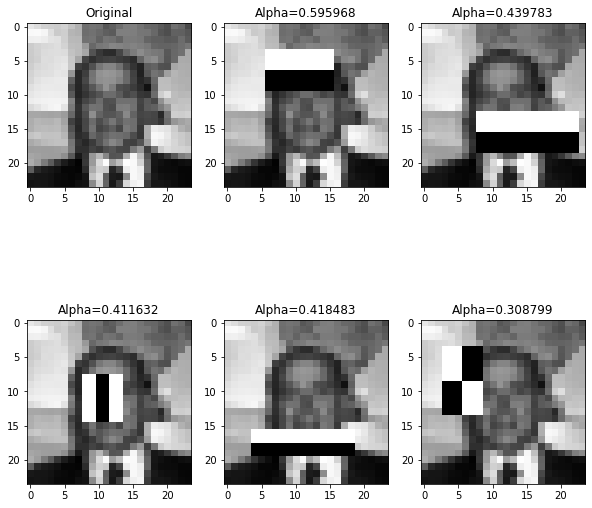

In [137]:
# Plot Haar features
img = (trainList[100]*255).astype(np.uint8)
haarsPerRow = 3
haars = 5
fig,axes = plt.subplots(int(np.floor(haars/haarsPerRow))+1, haarsPerRow,figsize=(10,10))
ax = axes.ravel()
ax[0].imshow(img, cmap='gray', vmin=0, vmax=255)
ax[0].title.set_text("Original")
colorWhite = (255,255,255)
colorBlack = (0,0,0)
for haarID in range(1,haars+1):
    img = (trainList[100]*255).astype(np.uint8)
    for r in range(0,len(haarList[haarID]),2):
        pt1White = haarList[haarID][r][0]
        pt2White = haarList[haarID][r][1]
        cv2.rectangle(img, pt1White, pt2White, colorWhite, -1)
        if (r+1)<len(haarList[haarID]):
            pt1Black = haarList[haarID][r+1][0]
            pt2Black = haarList[haarID][r+1][1]
            cv2.rectangle(img, pt1Black, pt2Black, colorBlack, -1)
    ax[haarID].imshow(img, cmap='gray', vmin=0, vmax=255)
    ax[haarID].title.set_text("Alpha="+str(round(alphaList[haarID],6)))
numTrain = 0
numTrain = maxFaces

In [138]:
# Testing
# Merge datasets (faces and Non Faces)
maxFaces = 300
maxNonFaces = 300
dataFace = testFace[0:maxFaces]
dataNonFace = testNonFace[0:maxNonFaces]
testList = dataFace + dataNonFace
faceLabels = [1]*len(dataFace)
nonfaceLabels = [-1]*len(dataNonFace)
yLabels = np.array(faceLabels+nonfaceLabels)

# Strong Classifier
def classifyHaar(testList,haarList,alphaList,threshold,T):
    accClass = np.zeros(len(testList))
    for i in range(0,len(haarList)):
        haarValue = getHaarValueSimple(testList, haarList[i]) 
        ht = (haarValue>T)*2-1 # Haar classification faces:+1, nonfaces:-1
        accClass += ht*alphaList[i]
    testLabels = (accClass>=threshold)*2-1
    return testLabels,accClass

# Accuracy Calculation
thresHaar = 0 # F(x) threshold
testLabels,_ = classifyHaar(testList,haarList,alphaList,thresHaar,threshold)
testAcc = round(sum(yLabels==testLabels)/len(yLabels),3)
TPR = round(sum(faceLabels==testLabels[0:maxFaces])/maxFaces,3)
TNR = round(sum(nonfaceLabels==testLabels[maxFaces::])/maxNonFaces,3)
print("Accuracy:",testAcc)
print("True Positive Rate:",TPR)
print("True Negative Rate:",TNR)

# Save strong classifier params in XML file
rootText = "Train Size:"+str(numTrain)+", Threshold:"+str(threshold)+", Iteractions:"+str(maxIter)+\
", Upper Limit:"+str(upLimit)+", Lower Limit:"+str(lowLimit)+", Equ:"+str(equEnable)
paramsName = "Params_"+"TPR_"+str(TPR)+"_TNR_"+str(TNR)+".xml"
saveParams(haarList,alphaList,paramsName,rootText)

Accuracy: 0.89
True Positive Rate: 0.88
True Negative Rate: 0.9


Text(0.5, 1.0, 'ROC Haar Features Adaboost')

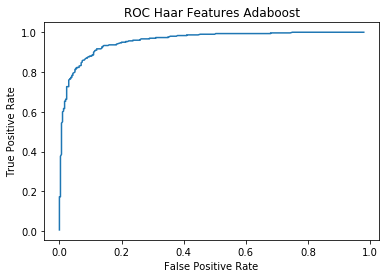

In [139]:
# Plot ROC Curve
plt.figure()
startThres = -5
endThres = 5
lenROC = 1000
pltFPR=np.zeros(lenROC)
pltTPR=np.zeros(lenROC)
for i in range(0,lenROC):
    thresHaar = startThres+i/(lenROC-1)*(endThres-startThres)
    testLabels,_ = classifyHaar(testList,haarList,alphaList,thresHaar,threshold)
    pltTPR[i] = sum(faceLabels==testLabels[0:maxFaces])/maxFaces
    pltFPR[i] = 1-sum(nonfaceLabels==testLabels[maxFaces::])/maxNonFaces

plt.plot(pltFPR,pltTPR)
plt.xlabel("False Positive Rate") 
plt.ylabel("True Positive Rate") 
plt.title("ROC Haar Features Adaboost")